Shooting Value
==============

* Sh/90 - 0.5
* npxG/90 - 0.5


Passing Value
=============

* xAG - 0.2
* xA - 0.2
* KP - 0.175
* PPA - 0.175
* 1/3 - 0.125
* PrgP - 0.125


Dribble Value
=============

* Att Pen - 0.235
* SuccDri - 0.118
* PrgC - 0.176
* 1/3 - 0.118
* CPA - 0.176
* Mis + Dis (inverse) - 0.059
* Fld 0.118


In [9]:
import pandas as pd

def clean_dataframe(df):
    # Remove rows where Player column contains 'Player' (these are repeated headers)
    df = df[df[('Unnamed: 1_level_0', 'Player')] != 'Player']
    return df

def scrape_metrics(min_90s=6):
    # Possession data
    df_possession = pd.read_html("https://fbref.com/en/comps/Big5/possession/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_possession"})[0]
    
    df = df_possession[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 3_level_0', 'Pos'),
        ('Unnamed: 8_level_0', '90s'),
        ('Carries', 'CPA'),
        ('Carries', 'Dis'),
        ('Touches', 'Att Pen'),
        ('Carries', 'Mis'),
        ('Take-Ons', 'Succ'),
        ('Carries', '1/3'),
        ('Carries', 'PrgC')
    ]]
    
    # Clean the dataframe to remove repeated headers
    df = clean_dataframe(df)
    
    # Create unique identifier
    df['player_id'] = df[('Unnamed: 1_level_0', 'Player')] + ' - ' + df[('Unnamed: 4_level_0', 'Squad')]

    # Misc data
    df_misc = pd.read_html("https://fbref.com/en/comps/Big5/misc/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_misc"})[0]
    df_misc = df_misc[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Performance', 'Fld')
    ]]
    df_misc = clean_dataframe(df_misc)
    df_misc['player_id'] = df_misc[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_misc[('Unnamed: 4_level_0', 'Squad')]

    # First merge
    df = pd.merge(
        df,
        df_misc.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Passing data
    df_passing = pd.read_html("https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_passing"})[0]

    df_pass_cmp = df_passing[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Unnamed: 29_level_0', 'PPA'),
        ('Unnamed: 28_level_0', '1/3'),
        ('Unnamed: 31_level_0', 'PrgP'),
        ('Unnamed: 27_level_0', 'KP'),
        ('Unnamed: 24_level_0', 'xAG'),
        ('Expected', 'xA'),
    ]]
    df_pass_cmp = clean_dataframe(df_pass_cmp)
    df_pass_cmp['player_id'] = df_pass_cmp[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_pass_cmp[('Unnamed: 4_level_0', 'Squad')]

    # Second merge
    df = pd.merge(
        df,
        df_pass_cmp.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Shooting data
    df_shooting = pd.read_html("https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats",
                    attrs={"id": "stats_shooting"})[0]
    df_shooting = df_shooting[[
        ('Unnamed: 1_level_0', 'Player'),
        ('Unnamed: 4_level_0', 'Squad'),
        ('Expected', 'npxG'),
        ('Standard', 'Sh')
    ]]
    df_shooting = clean_dataframe(df_shooting)
    df_shooting['player_id'] = df_shooting[('Unnamed: 1_level_0', 'Player')] + ' - ' + df_shooting[('Unnamed: 4_level_0', 'Squad')]

    # Third merge
    df = pd.merge(
        df,
        df_shooting.drop([('Unnamed: 1_level_0', 'Player'), ('Unnamed: 4_level_0', 'Squad')], axis=1),
        on='player_id',
        how='left'
    )

    # Drop the temporary player_id column
    df = df.drop('player_id', axis=1)

    # Rename columns
    df.columns = [
        "player", "team", "position", "90s",
        "carries_pa", "dispossessed", "touches_pa", "miscontrols", "succ_takeons", "carries_final_third", "prog_carries",
        "fouls_drawn",
        "passes_pa", "passes_final_third", "prog_passes", "key_passes", "xAG", "xA",
        "npxG", 'shots'
    ]

    # Convert to numeric and adjust metrics
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')
    
    metrics_to_adjust = [
        'carries_pa', 'dispossessed', 'touches_pa', "miscontrols", "succ_takeons", "carries_final_third", "prog_carries",
        'fouls_drawn',
        "passes_pa", "passes_final_third", "prog_passes", "key_passes", "xAG", "xA",
        'npxG', 'shots'
    ]
    
    for metric in metrics_to_adjust:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df[metric] = df[metric] / df['90s']

    df["carry_losses"] =  df["miscontrols"] + df["dispossessed"]

    df = df.drop(["miscontrols", "dispossessed"], axis=1)

    # Filter conditions
    df = df[df['90s'] > min_90s]
    df = df[df['position'].str.contains('FW')]

    return df

# Try running with the cleaned data
df = scrape_metrics(min_90s=8)
print(df.head(20))

C:\Users\Owner\AppData\Local\Temp\ipykernel_1928\3179928745.py:70: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = pd.merge(


                             player             team position   90s  \
5                     Himad Abdelli           Angers    MF,FW  16.8   
12                   Matthis Abline           Nantes       FW  14.6   
14                Zakaria Aboukhlal         Toulouse    MF,FW  15.8   
21                       Akor Adams      Montpellier       FW  11.9   
22                        Che Adams           Torino       FW  13.8   
24                     Junior Adamu         Freiburg       FW  10.1   
35                 Oladapo Afolayan        St. Pauli    FW,MF  13.3   
54                  Ludovic Ajorque            Brest       FW  13.5   
60                Maghnes Akliouche           Monaco    FW,MF  12.3   
72                  Mohamed Ali Cho             Nice    FW,MF   9.8   
76                    Jim Allevinah           Angers       FW   9.7   
77   Domingos André Ribeiro Almeida         Valencia    MF,FW   9.5   
83                   Adrià Altimira          Leganés    DF,FW   8.6   
87    

C:\Users\Owner\AppData\Local\Temp\ipykernel_1928\3179928745.py:98: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop('player_id', axis=1)


In [10]:
def calculate_triple_threat(df, additional_players=None):
    """
    Calculate triple threat scores for players.
    
    Parameters:
    df (pd.DataFrame): Original dataframe with player statistics
    additional_players (pd.DataFrame, optional): Additional players to include in analysis
    
    Returns:
    pd.DataFrame: DataFrame with triple threat scores
    """
    # Make a copy of the input DataFrame
    if additional_players is not None:
        df = pd.concat([df, additional_players], ignore_index=True).copy()
    else:
        df = df.copy()
    
    # List of metrics to calculate percentiles for
    metrics = [
        'touches_pa', 'succ_takeons', 'carries_final_third', 'carries_pa', 'prog_carries',
        'fouls_drawn', 'passes_pa', 'passes_final_third', 'prog_passes', 'key_passes',
        'xAG', 'xA', 'npxG', 'shots'
    ]

    # Calculate percentiles for regular metrics (higher is better)
    for metric in metrics:
        percentile_col = f"{metric}_percentile"
        df.loc[:, percentile_col] = df[metric].rank(pct=True) * 100

    # Calculate percentile for carry_losses (lower is better, so invert)
    df.loc[:, 'carry_losses_percentile'] = (1 - df['carry_losses'].rank(pct=True)) * 100

    # Create result DataFrame with all columns we'll need
    result_columns = ['player', 'team', 'shooting_score', 'carrying_score', 'passing_score', 'triple_threat_score']
    df_triple_threat = pd.DataFrame(columns=result_columns)
    
    # Copy player and team columns
    df_triple_threat['player'] = df['player']
    df_triple_threat['team'] = df['team']

    # Calculate shooting score
    df_triple_threat.loc[:, 'shooting_score'] = (
        df['npxG_percentile'] * 0.5 + 
        df['shots_percentile'] * 0.5
    )

    # Calculate carrying score
    df_triple_threat.loc[:, 'carrying_score'] = (
        df['touches_pa_percentile'] * 0.235 +
        df['succ_takeons_percentile'] * 0.118 +
        df['carries_final_third_percentile'] * 0.118 +
        df['fouls_drawn_percentile'] * 0.118 +
        df['carries_pa_percentile'] * 0.176 +
        df['carry_losses_percentile'] * 0.059 +
        df['prog_carries_percentile'] * 0.176
    )

    # Calculate passing score
    df_triple_threat.loc[:, 'passing_score'] = (
        df['passes_pa_percentile'] * 0.175 +
        df['passes_final_third_percentile'] * 0.125 +
        df['prog_passes_percentile'] * 0.125 +
        df['key_passes_percentile'] * 0.175 +
        df['xAG_percentile'] * 0.2 +
        df['xA_percentile'] * 0.2
    )

    # Calculate triple threat score
    df_triple_threat.loc[:, 'triple_threat_score'] = (
        df_triple_threat['shooting_score'] +
        df_triple_threat['carrying_score'] +
        df_triple_threat['passing_score']
    ) / 3

    return df_triple_threat.sort_values(by='triple_threat_score', ascending=False)

df_triple_threat = calculate_triple_threat(df)
df_triple_threat.head(20)

,player,team,shooting_score,carrying_score,passing_score,triple_threat_score
595,Ousmane Dembélé,Paris S-G,97.285714,85.810286,99.15,94.082
1700,Michael Olise,Bayern Munich,81.928571,88.304286,98.042857,89.425238
2424,Lamine Yamal,Barcelona,87.285714,89.160571,91.785714,89.410667
1880,Raphinha,Barcelona,94.571429,79.077429,94.542857,89.397238
1411,Omar Marmoush,Eint Frankfurt,95.428571,88.770571,79.714286,87.971143
1109,Vinicius Júnior,Real Madrid,83.571429,93.902571,83.371429,86.948476
1994,Mohamed Salah,Liverpool,96.285714,76.155,86.564286,86.335
498,Kingsley Coman,Bayern Munich,87.714286,81.114,90.078571,86.302286
1311,Ademola Lookman,Atalanta,93.428571,81.399143,79.535714,84.78781
205,Bradley Barcola,Paris S-G,95.857143,83.862429,72.8,84.17319


In [11]:
new_players = pd.DataFrame([
    {
        'player': 'Mo Salah (19/20)',
        'team': 'Liverpool',
        'touches_pa': 9.09,
        'succ_takeons': 1.56,
        'carries_final_third': 1.59,
        'carries_pa': 2.25,
        'prog_carries': 3.28,
        'fouls_drawn': 0.56,
        'passes_pa': 1.78,
        'passes_final_third': 1.28,
        'prog_passes': 2.84,
        'key_passes': 1.88,
        'xAG': 0.24,
        'xA': 0.22,
        'npxG': 0.52,
        'shots': 4.03,
        'carry_losses': 4.84
    },
        {
        'player': 'Roberto Firmino (19/20)',
        'team': 'Liverpool',
        'touches_pa': 6.59,
        'succ_takeons': 1.57,
        'carries_final_third': 1.87,
        'carries_pa': 1.05,
        'prog_carries': 2.71,
        'fouls_drawn': 0.48,
        'passes_pa': 0.93,
        'passes_final_third': 2.23,
        'prog_passes': 3.34,
        'key_passes': 1.57,
        'xAG': 0.20,
        'xA': 0.12,
        'npxG': 0.42,
        'shots': 2.98,
        'carry_losses': 3.94
    },
        {
        'player': 'Sadio Mane (19/20)',
        'team': 'Liverpool',
        'touches_pa': 6.36,
        'succ_takeons': 2.26,
        'carries_final_third': 3.38,
        'carries_pa': 2.03,
        'prog_carries': 5.21,
        'fouls_drawn': 1.67,
        'passes_pa': 2.36,
        'passes_final_third': 2.20,
        'prog_passes': 4.20,
        'key_passes': 1.93,
        'xAG': 0.22,
        'xA': 0.17,
        'npxG': 0.43,
        'shots': 2.52,
        'carry_losses': 5.15
    }
])

results_with_new = calculate_triple_threat(df, new_players)

# Filter to show only the new players we added
new_player_names = new_players['player'].tolist()
new_player_results = results_with_new[results_with_new['player'].isin(new_player_names)]

# Display results with rounded scores
new_player_results

,player,team,shooting_score,carrying_score,passing_score,triple_threat_score
352,Sadio Mane (19/20),Liverpool,79.745042,83.58272,78.987252,80.771671
350,Mo Salah (19/20),Liverpool,95.750708,67.630878,72.868272,78.749953
351,Roberto Firmino (19/20),Liverpool,86.11898,62.060907,61.395184,69.858357


In [12]:
def print_component_rankings(df_results, component, n=5):
    print(f"\nTop {n} Players by {component.title()} Score:")
    print(df_results.sort_values(by=f"{component}_score", ascending=False).head(n))

# Example component analysis
print_component_rankings(results_with_new, "shooting")
print_component_rankings(results_with_new, "carrying")
print_component_rankings(results_with_new, "passing")


Top 5 Players by Shooting Score:
                player             team shooting_score carrying_score  \
319        Deniz Undav        Stuttgart      99.858357      43.122946   
265      Mateo Retegui         Atalanta       98.15864      34.904533   
305  Alexander Sørloth  Atlético Madrid      97.592068      46.954391   
135     Erling Haaland  Manchester City      97.450425      38.540227   
76     Ousmane Dembélé        Paris S-G      97.308782       85.79745   

    passing_score triple_threat_score  
319     45.913598           62.964967  
265     29.107649           54.056941  
305     32.935552            59.16067  
135     11.664306           49.218319  
76      99.157224           94.087819  

Top 5 Players by Carrying Score:
                  player            team shooting_score carrying_score  \
161      Vinicius Júnior     Real Madrid      83.144476      93.871105   
183          Rafael Leão           Milan      78.611898      89.529178   
339         Lamine Yamal       

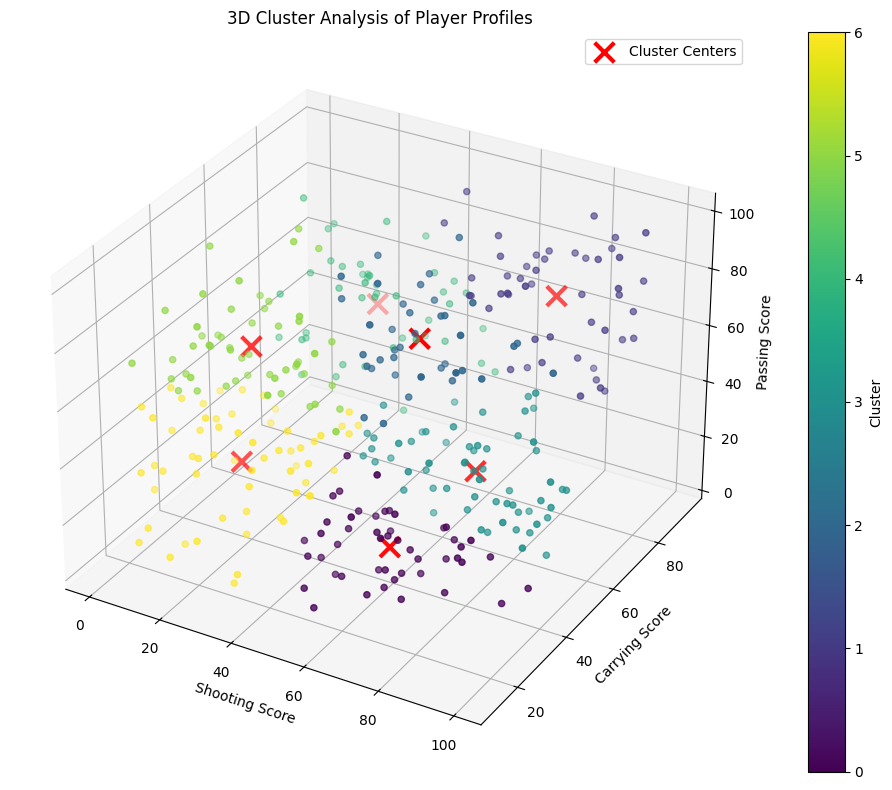


Cluster Analysis:
--------------------------------------------------------------------------------

Cluster 0 - Strong Shooting
Size: 48 players

Cluster Center Scores:
- Shooting: 64.82
- Carrying: 31.73
- Passing:  19.02

Example Players (closest to center):
- Borja Iglesias (Celta Vigo)
- Kiké (Alavés)
- Moritz Broschinski (Bochum)
- Artem Dovbyk (Roma)
- Jamie Vardy (Leicester City)
--------------------------------------------------------------------------------

Cluster 1 - Triple Threat Forward
Size: 48 players

Cluster Center Scores:
- Shooting: 78.61
- Carrying: 78.23
- Passing:  76.30

Example Players (closest to center):
- Harvey Barnes (Newcastle Utd)
- Matheus Cunha (Wolves)
- Mason Greenwood (Marseille)
- Bukayo Saka (Arsenal)
- Luis Díaz (Liverpool)
--------------------------------------------------------------------------------

Cluster 2 - Passing Specialist with Strong Shooting
Size: 38 players

Cluster Center Scores:
- Shooting: 59.63
- Carrying: 50.87
- Passing:  74

In [144]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define features for clustering
features = ["shooting_score", "carrying_score", "passing_score"]
X = df_triple_threat[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create initial centers with one forced carrying specialist
initial_centers = np.zeros((7, 3))  # 8 clusters, 3 features
# Set the carrying specialist center (in scaled space)
#initial_centers[0] = [0, 2, 0]  # High carrying (2 std above mean), average others

# Initialize KMeans with our initialization
kmeans = KMeans(n_clusters=7, random_state=77, n_init=1, init=initial_centers)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

# Add clusters to dataframe
df_clustered = df_triple_threat.copy()
df_clustered["cluster"] = clusters

# Get cluster centers in original scale
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

# Profile analysis for each cluster
cluster_profiles = {}
for i in range(7):
    cluster_data = df_clustered[df_clustered['cluster'] == i]
    
    profile = {
        'center': dict(zip(features, centers_original[i])),
        'size': len(cluster_data),
        'players': cluster_data[['player', 'team'] + features].to_dict('records'),
        'avg_scores': {
            'shooting': cluster_data['shooting_score'].mean(),
            'carrying': cluster_data['carrying_score'].mean(),
            'passing': cluster_data['passing_score'].mean()
        }
    }
    
    # Get the center scores
    shooting = profile['center']['shooting_score']
    carrying = profile['center']['carrying_score']
    passing = profile['center']['passing_score']
    
    # Define thresholds for different skill levels
    triple_threat_threshold = 70 # Triple threat level
    specialist_threshold = 75  # Specialist level
    strong_threshold = 60      # Strong level
    capable_threshold = 50     # Capable level
    
    # Get highest attribute and its score (with rounding)
    scores = [('Shooting', round(shooting)), ('Carrying', round(carrying)), ('Passing', round(passing))]
    primary_attr, primary_score = max(scores, key=lambda x: x[1])
    
    # Check for Triple Threat Forward first using rounded scores
    if all(round(score[1]) > triple_threat_threshold for score in scores):
        profile['primary_attribute'] = "Triple Threat Forward"
    else:
        # Determine skill level based on thresholds with rounded scores
        if primary_score >= specialist_threshold:
            prefix = f"{primary_attr} Specialist"
        elif primary_score >= strong_threshold:
            prefix = f"Strong {primary_attr}"
        elif primary_score >= capable_threshold:
            prefix = f"Capable {primary_attr}"
        else:
            prefix = f"Bad Forwards"
            
        # Check for secondary attributes using rounded scores
        secondary_scores = [s for s in scores if s[0] != primary_attr and s[1] >= strong_threshold]
        if secondary_scores:
            secondary_attrs = [f"{s[0]}" for s in secondary_scores]
            profile['primary_attribute'] = f"{prefix} with Strong {' & '.join(secondary_attrs)}"
        else:
            profile['primary_attribute'] = prefix
    
    # Store the profile in cluster_profiles
    cluster_profiles[i] = profile

# Create visualization code
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_clustered['shooting_score'],
                    df_clustered['carrying_score'],
                    df_clustered['passing_score'],
                    c=clusters,
                    cmap='viridis')

ax.scatter(centers_original[:, 0],
          centers_original[:, 1],
          centers_original[:, 2],
          c='red',
          marker='x',
          s=200,
          linewidth=3,
          label='Cluster Centers')

ax.set_xlabel('Shooting Score')
ax.set_ylabel('Carrying Score')
ax.set_zlabel('Passing Score')
ax.set_title('3D Cluster Analysis of Player Profiles')

plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.tight_layout()
plt.show()

# Print cluster information
print("\nCluster Analysis:")
print("-" * 80)
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCluster {cluster_id} - {profile['primary_attribute']}")
    print(f"Size: {profile['size']} players")
    print("\nCluster Center Scores:")
    print(f"- Shooting: {profile['center']['shooting_score']:.2f}")
    print(f"- Carrying: {profile['center']['carrying_score']:.2f}")
    print(f"- Passing:  {profile['center']['passing_score']:.2f}")
    
    print("\nExample Players (closest to center):")
    cluster_players = df_clustered[df_clustered['cluster'] == cluster_id]
    
    # Calculate distances and get top 5 closest players
    center = np.array([profile['center']['shooting_score'],
                      profile['center']['carrying_score'],
                      profile['center']['passing_score']])
    
    distances = []
    for idx, player in cluster_players.iterrows():
        point = np.array([player['shooting_score'],
                        player['carrying_score'],
                        player['passing_score']])
        distance = np.linalg.norm(point - center)
        distances.append((player['player'], player['team'], distance))
    
    distances.sort(key=lambda x: x[2])
    for player, team, dist in distances[:5]:
        print(f"- {player} ({team})")
    
    print("-" * 80)

In [149]:
# To print all players from a specific cluster (e.g., cluster 2)
cluster_number = 6  # Change this to whichever cluster you want to see

# Get all players from the cluster with their scores
cluster_players = df_clustered[df_clustered['cluster'] == cluster_number].sort_values(
    by=['shooting_score', 'carrying_score', 'passing_score'], 
    ascending=False
)[['player', 'team', 'shooting_score', 'carrying_score', 'passing_score']]

print(f"\nAll Players in Cluster {cluster_number}:")
print("-" * 80)
print(cluster_players.to_string(index=False))


All Players in Cluster 6:
--------------------------------------------------------------------------------
                player            team shooting_score carrying_score passing_score
         Shuto Machino   Holstein Kiel      46.642857          21.57     39.485714
           Boulaye Dia           Lazio      44.071429      29.705429     42.117857
      Valentin Mihaila           Parma           43.5      35.260714     47.303571
        Sandro Ramírez      Las Palmas      42.428571         47.642     37.767857
      Maximilian Beier        Dortmund      41.571429      26.348857        41.225
         Selim Amallah      Valladolid           41.5         33.724     26.435714
               Vitinha           Genoa      41.285714      49.356429     43.767857
       Mikel Oyarzabal   Real Sociedad      41.142857      24.027143     25.182143
       Chrisantus Uche          Getafe      39.357143      45.954714     24.846429
                 Jofre        Espanyol      38.571429      56.